In [365]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import LinReg
import pandas as pd

## Defining paramters for the SGA

In [366]:
pop_size = 100
chromosome_length = 90
generation_number = 1
crossover_rate = 0.9
mutation_rate = 0.1
num_parents = int(np.floor(pop_size/2))
g_max = 10
enable_constraint = (False, [5, 10])

data = pd.read_csv("dataset.txt", header=None)
regressor = LinReg.LinReg()

## Defining the Individual

In [367]:
class Individual:
    def __init__(self, genotype, age) -> None:
        self.genotype = genotype
        self.phenotype = int(genotype, 2)
        self.sin_fitness = self.calculate_sin_fitness()
        self.children = []
        self.age = age
        self.rmse_fitness = self.calculate_rmse_fitness()

    def scaled_phenotype(self):
        genotype_length = len(self.genotype)
        scaling_factor = (2**7) / (2**genotype_length)
        scaled_value = self.phenotype * scaling_factor
        return scaled_value
    
    def calculate_sin_fitness(self):
        x = self.scaled_phenotype()

        # Handle if there is a constraint
        if enable_constraint[0]:
            distance = self.calculate_distance(x)
            fitness = np.sin(x) + 1 - distance
            if fitness < 0:
                return 0
            else:
                return fitness
        else:
            # Scaling by 1 to avoid negative values
            return np.sin(x) + 1
    
    def calculate_rmse_fitness(self):
        y = np.array([int(bit) for bit in self.genotype])
        X = regressor.get_columns(data.values, y)
        return regressor.get_fitness(X[:,:-1], X[:,-1])

    def calculate_distance(self, x):
        lower_bound, upper_bound = enable_constraint[1][0], enable_constraint[1][1]
        if x < lower_bound:
            return lower_bound - x
        elif x > upper_bound:
            return x - upper_bound
        else:
            return 0
    
    def add_children(self, children):
        self.children += children

    def grow_older(self):
        self.age += 1
    
    def __repr__(self):
        return f"Individual(genotype={self.genotype}, phenotype={self.phenotype}, sin_fitness={self.sin_fitness}, age={self.age})"
    
    def __hash__(self):
        return hash((self.genotype, self.phenotype))

## Sin Synthetic Problem

*a) Implement a function to generate an initial population for your genetic
algorithm.*

We are choosing to initialize the population, according to the size parameters. The actual genotypes (0's and 1's) will be generated randomly.

In [368]:
def init_population():
    population = []
    
    for _ in range(pop_size):
        new_genotype = ""
        for _ in range(chromosome_length):
            new_genotype += str(random.randint(0,1))

        new_individual = Individual(new_genotype, age=0)
        population.append(new_individual)
    return population

*b) Implement a parent selection function for your genetic algorithm. This function
should find the fittest individuals in the population, and select parents based
on this fitness.*

Here we are using the fitness function given by the sine function, as explained in the task. Moreover we are implementing a roulette-wheel approach as parent selection.

In [369]:
def roulette_wheel_parent_selection(population, use_dataset):    
    # Probability of choosing each individual based on the roulette wheel approach
    if use_dataset:
        # Minimizing
        total_fitness = sum(1.0 / individual.rmse_fitness for individual in population)
        probabilities = [(1.0 / individual.rmse_fitness) / total_fitness for individual in population]
        print("Prob array", probabilities)
        print(sum(probabilities))
    else:
        # Maximizing
        total_fitness = sum(individual.sin_fitness for individual in population)
        probabilities = [individual.sin_fitness/total_fitness for individual in population]

    # Choosing num_parents parents with the above probabilities for each individual
    parents = np.random.choice(population, size=num_parents, p=probabilities)
    
    return list(parents)

*c) Implement a function that creates two offspring from two parents through
crossover. The offspring should also have a chance of getting a random
mutation.*

In [370]:
def crossover(parent1, parent2):
    gene_cutoff = random.randint(1, chromosome_length - 1)

    genotype_1 = parent1.genotype[: gene_cutoff] + parent2.genotype[gene_cutoff:]
    genotype_2 = parent2.genotype[: gene_cutoff] + parent1.genotype[gene_cutoff:]

    child_1 = Individual(mutate(genotype_1), age=0)
    child_2 = Individual(mutate(genotype_2), age=0)

    parent1.add_children([child_1, child_2])
    parent2.add_children([child_1, child_2])

    return child_1, child_2
        
def mutate(genotype):
    if np.random.random() < mutation_rate:
        char_list = list(genotype)

        random_index = np.random.randint(len(char_list))

        char_list[random_index] = '0' if char_list[random_index] == '1' else '1'

        return ''.join(char_list)
    else:
        return genotype

*d) Implement survivor selection.*

- For a 1-person team: Implement one survivor selection function that
selects the survivors of a population based on their fitness.
- For a 2-person team: Implement two such survivor selection functions.

Survivor selection function 1 chooses based on age. It sorts the population based on age, from youngest to oldest. Then outputs the youngest individuals.

In [371]:
def age_selection(population):
    age_sorted_population = sorted(population, key=lambda x: x.age)
    return age_sorted_population[:pop_size]

Survivor selection function 2 uses tounrament selection. A set of individuals is randomly chosen, and the one with the highest fitness within this group is selected to survive. This process is repeated until the desired number of survivors is reached.

In [372]:
def tournament_selection(population, use_dataset):
    contestants = population.copy()
    winners = []

    while len(winners) != pop_size:
        if len(contestants) > 1:
            size = random.randint(2, len(contestants))
            trial = np.random.choice(contestants, size, replace=False)
            
            if use_dataset:
                winner = min(trial, key=lambda x: x.rmse_fitness)
            else:
                winner = max(trial, key=lambda x: x.sin_fitness)
            contestants.remove(winner)
            
            winners.append(winner)
        else:
            winner = contestants[0]
            winners.append(winner)
    
    return list(winners)

*e) Connect all the implemented functions to complete the genetic algorithm, and
run the algorithm with the sine fitness function. Throughout the generations
plot the individuals, values and fitness values with the sine wave.*

In [373]:
def sga(survivor_selection, use_dataset):
    g = 0
    population = init_population()

    while g < g_max:
        g += 1
        age_population(population)
        
        avg_fitness = plot_generation(population, generation=g, use_dataset=use_dataset)
        print("Average fitness of generation", g, "is", avg_fitness)
        print("Population size", len(population))
        new_population = []

        # Creating parents (mating pool)
        parents = roulette_wheel_parent_selection(population, use_dataset)
        
        # Shuffling mating pool
        random.shuffle(parents)
        parent1, parent2 = random.sample(parents, 2)

        while len(new_population) < len(population):
            parent1, parent2 = random.sample(parents, 2)
            
            if np.random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
                new_population.extend([child1, child2])
                if parent1 not in new_population:
                    new_population.append(copy.deepcopy(parent1))
                if parent2 not in new_population:
                    new_population.append(copy.deepcopy(parent2))

        # Survivor selection
        if survivor_selection == 'age':
            population = age_selection(new_population)
        elif survivor_selection == 'tournament':
            population = tournament_selection(new_population, use_dataset)
        
        print("\n")


    return population


def plot_generation(population, generation, use_dataset):
    if not use_dataset:
        x = np.linspace(0, 128, 500)
        y = np.sin(x)
        plt.plot(x, y)

    fitness_pool = []

    # Plot each individual in the population
    for individual in population:
        phenotype = individual.scaled_phenotype()
        if use_dataset:
            fitness = individual.rmse_fitness
        else:
            fitness = individual.sin_fitness - 1
            plt.scatter(phenotype, fitness, alpha=1, color = 'orange') 
        fitness_pool.append(fitness) 

    if not use_dataset:
        plt.title('Population plot, generation ' + str(generation))
        plt.xlabel('Phenotype')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()

    return np.average(fitness_pool)

def age_population(population):
    ages = []
    for individual in population:
        individual.grow_older()
        ages.append(individual.age)

    print("Max age:", max(ages), "\nMin age:", min(ages))


problem: the ages of the individuals are not correct

Max age: 1 
Min age: 1


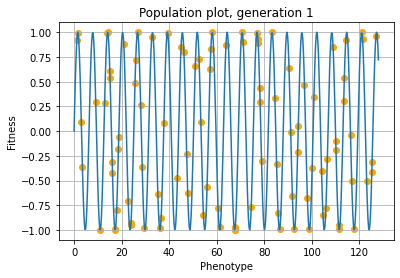

Average fitness of generation 1 is -0.031231687465075417
Population size 100


Max age: 2 
Min age: 1


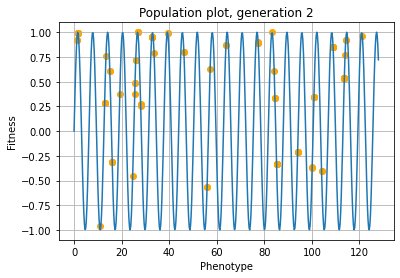

Average fitness of generation 2 is 0.4683945959893185
Population size 100


Max age: 3 
Min age: 1


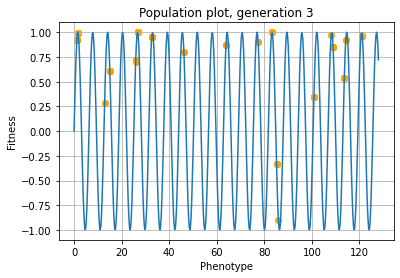

Average fitness of generation 3 is 0.7502509074047424
Population size 100


Max age: 4 
Min age: 1


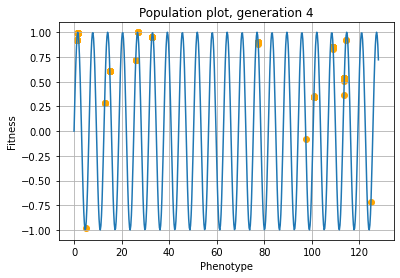

Average fitness of generation 4 is 0.6944119436572579
Population size 100


Max age: 5 
Min age: 1


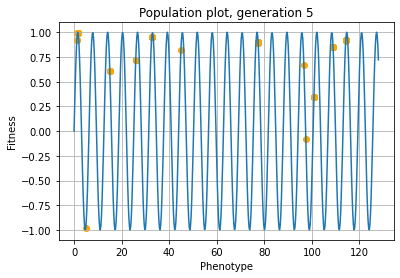

Average fitness of generation 5 is 0.80894279771348
Population size 100


Max age: 6 
Min age: 1


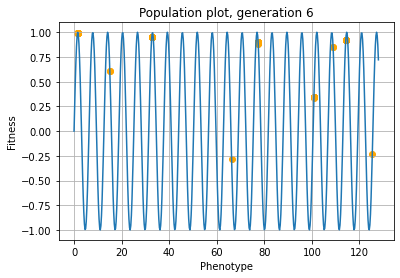

Average fitness of generation 6 is 0.8749074711348024
Population size 100


Max age: 6 
Min age: 1


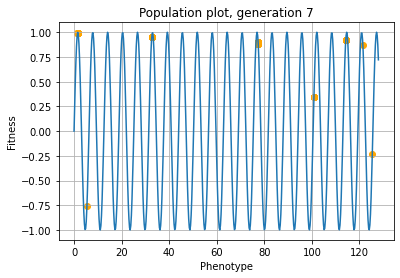

Average fitness of generation 7 is 0.875022160631414
Population size 100


Max age: 7 
Min age: 1


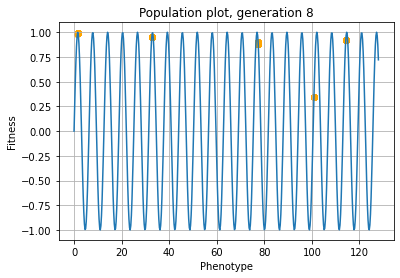

Average fitness of generation 8 is 0.9038106392697911
Population size 100


Max age: 8 
Min age: 1


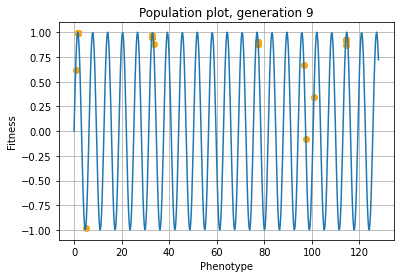

Average fitness of generation 9 is 0.9123408781421967
Population size 100


Max age: 5 
Min age: 1


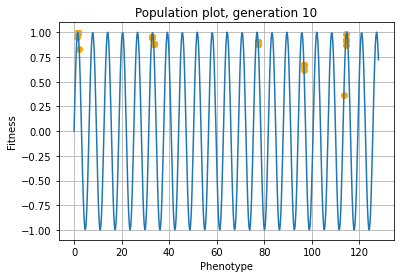

Average fitness of generation 10 is 0.9024828428599725
Population size 100




In [374]:
# Choose survivor selection method. Either 'age' or 'tournament'

population = sga(survivor_selection = 'age', use_dataset=False)

## Check how many duplicates

In [375]:
import statistics
from statistics import mode

def most_common_and_count(lst):
    most_common_obj = mode(lst)
    count = lst.count(most_common_obj)
    return most_common_obj, count

# Example usage with your population list
most_common_obj, count = most_common_and_count(population)
print(f"The most common object is: {most_common_obj}")
print(f"It appears {count} times in the population.")


The most common object is: Individual(genotype=000000101001001100100100100001101010001000001110010101000110001001100000111001110111000000, phenotype=12450853185320210558852544, sin_fitness=1.9601079603811604, age=0)
It appears 1 times in the population.


*f) This task is identical to e), however, we now add the constraint that the
solution must reside in the interval [5,10]. The constraint should not be
handled by scaling the real value of the bitstring into the new interval.
Throughout the generations plot the individuals, values and fitness values with
the sine wave.*

We are to handle a constraint. In the excersise we are taught how to utilize such constraints. 

*"Constraints can be handled indirectly by adding a penalty term to the fitness
function. The original fitness function f(x) is then transformed into f’(x) = f(x) +
P(d(x,F)), where d(x,F) is a distance metric of the infeasible point to the feasible
region F. The penalty function P is zero for feasible solutions and increases
proportionally with the distance to the feasible region."*

Max age: 1 
Min age: 1


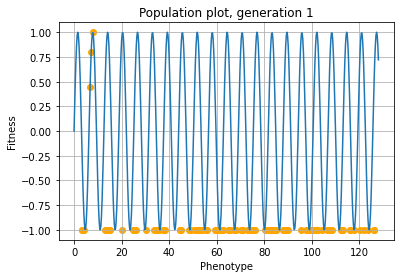

Average fitness of generation 1 is -0.947476333713374
Population size 100


Max age: 2 
Min age: 1


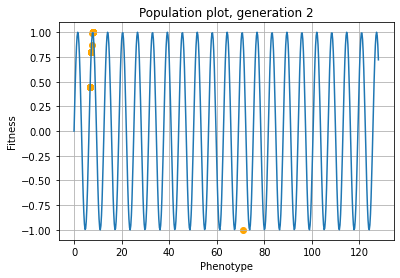

Average fitness of generation 2 is 0.7976017489687162
Population size 100


Max age: 3 
Min age: 1


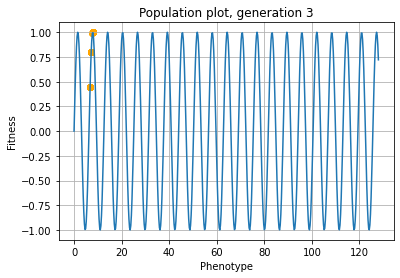

Average fitness of generation 3 is 0.8652155970556149
Population size 100


Max age: 4 
Min age: 1


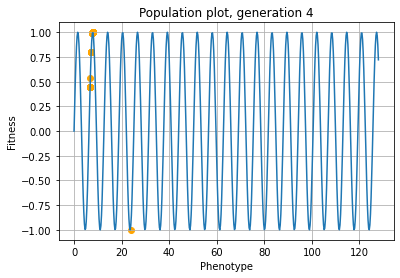

Average fitness of generation 4 is 0.8914775799808862
Population size 100


Max age: 5 
Min age: 1


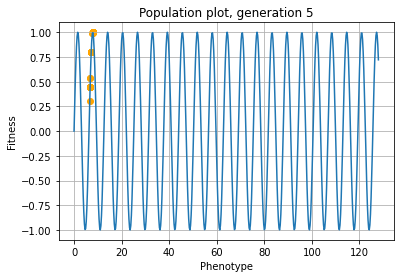

Average fitness of generation 5 is 0.8741550518160818
Population size 100


Max age: 5 
Min age: 1


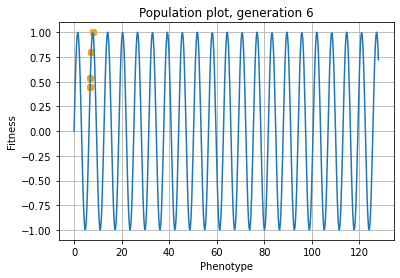

Average fitness of generation 6 is 0.8416044890013068
Population size 100


Max age: 6 
Min age: 1


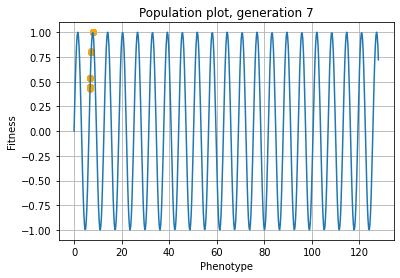

Average fitness of generation 7 is 0.8356655661716909
Population size 100


Max age: 7 
Min age: 1


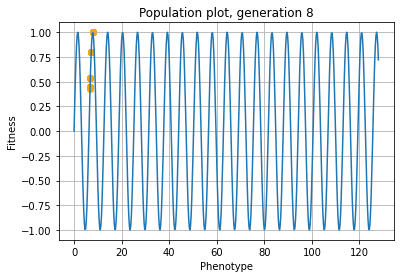

Average fitness of generation 8 is 0.8821261044349364
Population size 100


Max age: 7 
Min age: 1


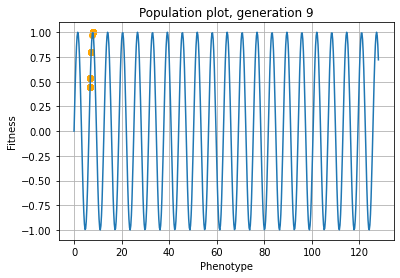

Average fitness of generation 9 is 0.9159166772720104
Population size 100


Max age: 5 
Min age: 1


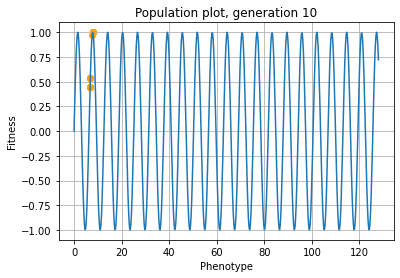

Average fitness of generation 10 is 0.9590305352955198
Population size 100




In [376]:
enable_constraint = (True, [5, 10])

population = sga(survivor_selection = 'age', use_dataset=False)

## For the feature selection problem

*g) Run the genetic algorithm on the provided dataset. Show the results, and
compare them to the results of not using any feature selection (given by
running the linear regression with all features selected). The points given here
depend on the achieved quality of the result and team size.*

- *For a 2-person team RMSE less than 0.124.*

Updating the chromosonme_length to match the dataset. **NOTE UNSURE OF THIS**

In [379]:
chromosome_length = data.shape[1]
enable_constraint = (False, [5, 10])

In [380]:
population = sga(survivor_selection = 'tournament', use_dataset=True)

Max age: 1 
Min age: 1
Average fitness of generation 1 is 0.15660725680653753
Population size 100
Prob array [0.007677961338722636, 0.00773596938551317, 0.007284781393412456, 0.011819722201594409, 0.01007797763086392, 0.010456320485173252, 0.009420395624412704, 0.0110041874392521, 0.006638094328379556, 0.010836399339627626, 0.01175185336069986, 0.012776997548532794, 0.011161131302979717, 0.011100180550678638, 0.007591789379442637, 0.007479691060283031, 0.01019217408958428, 0.010202878068763027, 0.01097037039953327, 0.007756888854138481, 0.010264464445165693, 0.010415244328632292, 0.012216980824842585, 0.010319888493198433, 0.007029593708010336, 0.011280058999420452, 0.007298099100817648, 0.01148507033803475, 0.010266939847358492, 0.010424743562301353, 0.012565558716368445, 0.010929472144884992, 0.010056399447244522, 0.011277164052072804, 0.012748709342211409, 0.007050047705047774, 0.010790182914845065, 0.006782216244079641, 0.006602191163374085, 0.010553331017108989, 0.0111817969627582